## Numerical schemes for hyperbolic equations enhanced by Scientific Machine Learning &mdash; Computer session

The goals of this computer session are to:
1. implement the necessary functions to train a PINN to approximate steady solutions to the advection equation with source term;
2. modify the basis functions of an existing Discontinuous Galerkin code to incorporate the PINN prior.

In this session, the problem under consideration is the advection equation with source term, with velocity $c = 1$:
$$
    \frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} = a u + b u^2.
$$
The unknown function is $u : \mathbb{R}^+ \times \mathbb{R} \to \mathbb{R}$, which depends on the time variable $t \geq 0$ and the space variable $x$.

The space domain is $x \in (0, 1)$, and the system parameters are:
- $a \in (0.5, 1)$, 
- $b \in (0.5, 1)$, 
- $u_0 \in (0.1, 0.2)$ the left boundary condtion: $u(t, 0) = u_0$ for all $t \geq 0$.

In [5]:
# necessary imports and torch setup
# nothing to modify in this cell

import os

import DG_scheme
import matplotlib.pyplot as plt
import numpy as np
import torch
from mesh import Mesh, run_and_plot, run_perturbation_analysis
from model import Network
from torch.autograd import grad

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")

torch.set_default_dtype(torch.double)
torch.set_default_device(device)

AttributeError: module 'torch' has no attribute 'set_default_device'

### 1/ PINN training

The core structure of a PINN is provided in the `model.py` file.
Do not hesitate to check it out, but it is not mandatory for this computer session.

**The goal is to implement five necessary functions**:
1. `u_exact`: the steady solution $u_\text{eq}$;
2. `get_u`: the boundary ansatz $\widetilde{W_\theta}$;
3. `residual`: the PDE residual $\mathcal{N}$;
4. `pde_loss`: the PDE loss function $\mathcal{J}_\text{PDE}$;
5. `data_loss`: the data loss function $\mathcal{J}_\text{data}$.

**Tips**:
1. calling the model: `model(x, a, b, u0)` $ = W_\theta(x, a, b, u_0)$;
2. computing a gradient: `grad(y, x, torch.ones_like(x), create_graph=True)[0]` computes the gradients of $y$ with respect to $x$;
3. all torch tensors should be at least two-dimensional (adding an empty dimension to a one-dimensional tensor can be done with `tensor[:, None]`);
4. the model has a `random` function for uniform sampling (you can check its documentation by printing `Network.random.__doc__`);
5. the model has a `cost_function` function to compute the loss (you can check its documentation by printing `Network.cost_function.__doc__`).

In [6]:
def u_exact(x, a, b, u0):
    """
    inputs: 
        x (float or tensor), 
        a (float or tensor), 
        b (float or tensor), 
        u0 (float or tensor)
    output: exact steady solution of the advection equation with source term, same shape as x
    """
    return a * u0 / ((a + b * u0) * torch.exp(-a * x) - b * u0)


def get_u(model, x, a, b, u0):
    """
    inputs: 
        model (neural network) -> W_θ,
        x (tensor), 
        a (tensor), 
        b (tensor), 
        u0 (tensor)
    output: approximation of the steady solution -> W_θ tilde
    """
    return u0 + x * model(x, a, b, u0)


def residual(model, x, a, b, u0):
    """
    inputs: 
        model (neural network) -> W_θ,
        x (tensor), 
        a (tensor), 
        b (tensor), 
        u0 (tensor)
    output: ODE residual
    """
    u = model.get_u(x, a, b, u0)
    u_x = grad(u, x, torch.ones_like(x), create_graph=True)[0]
    return u_x - a * u - b * u**2


def pde_loss(model, n_collocation):
    """
    inputs: 
        model (neural network) -> W_θ,
        n_collocation (int) -> the number of collocation points
    output: the PDE loss
    """
    shape = (n_collocation, 1)

    x = model.random(model.x_min, model.x_max, shape, requires_grad=True)
    a = model.random(model.a_min, model.a_max, shape, requires_grad=True)
    b = model.random(model.b_min, model.b_max, shape, requires_grad=True)
    u0 = model.random(model.u0_min, model.u0_max, shape, requires_grad=True)

    zeros = torch.zeros(shape)

    residual = model.residual(x, a, b, u0)

    return model.cost_function(residual, zeros)


def data_loss(model, n_data):
    """
    inputs: 
        model (neural network) -> W_θ,
        n_collocation (int) -> the number of collocation points
    output: the data loss
    """
    shape = (n_data, 1)

    x = model.random(model.x_min, model.x_max, shape)
    a = model.random(model.a_min, model.a_max, shape)
    b = model.random(model.b_min, model.b_max, shape)
    u0 = model.random(model.u0_min, model.u0_max, shape)

    u = model.u_exact(x, a, b, u0)

    u_pred = model.get_u(x, a, b, u0)

    return model.cost_function(u_pred, u)


model_args = [u_exact, get_u, residual, pde_loss, data_loss]

In [7]:
train = True  # trains the model
# train = False  # uses the trained model (only available after training)

if train:
    # new_training = False  # restarts training with the existing trained model
    new_training = True  # deletes the existing model and start a new training

    if new_training:
        try:
            os.remove(Network.DEFAULT_FILE_NAME)
        except FileNotFoundError:
            pass

    model = Network(model_args)

    n_epochs = 500  # number of epochs
    n_collocation = 10_000  # number of collocation points (for the PDE loss)
    n_data = 0  # number of data points (for the data loss)
    model.train(n_epochs=n_epochs, n_collocation=n_collocation, n_data=n_data)

else:
    model = Network(model_args)
    model.plot_result(random=True, n_plots=5)

NameError: name 'Network' is not defined

### 2/ Discontinuous Galerkin basis functions with prior

Once the model has been satisfactorily trained (say, once the loss is lower than $10^{-5}$), you can add it as a prior to the DG scheme.

The file `DG_scheme.py` contains the scheme, while the file `mesh.py` contains the implementation of the mesh.
Like before, feel free to have a look around these files, but it is not mandatory.

**The goal is to implement four necessary functions**:
1. `phi_0`: first basis function;
2. `d_phi_0`: derivative of the first basis function;
3. `phi_k`: k<sup>th</sup> basis function, for $k \geq 0$;
4. `d_phi_k`: derivative of the k<sup>th</sup> basis function, for $k \geq 0$.

**Tips**:
1. the `scheme` class, passed as input to each function, has an attribute `category`, a `str`, which controls the type of basis function:
    1. `"no_prior"` corresponds to the case where no prior is applied,
    2. the string must contain `"with_prior"` if a prior is applied;
2. you can predict the value of $u$ using the function `mesh.PINN.predict_u_from_numpy` (its documentation is available by printing `Network.predict_u_from_numpy.__doc__`);
3. you can predict the value of $\partial_x u$ using the function `mesh.PINN.predict_dxu_from_numpy` (its documentation is available by printing `Network.predict_dxu_from_numpy.__doc__`).

In [3]:
def phi_0(mesh, x, x0):
    """
    inputs:
        mesh (instance of the Mesh class),
        x (numpy array),
        x0 (numpy array)
    output:
        value of the first basis function at each point x
    """
    if mesh.category == "no_prior":
        return np.ones_like(x)
    elif "with_prior" in mesh.category:
        return mesh.PINN.predict_u_from_numpy(x, mesh)
    else:
        raise ValueError(f"category {mesh.category} not understood in phi_0")


def d_phi_0(mesh, x, x0):
    """
    inputs:
        mesh (instance of the Mesh class),
        x (numpy array),
        x0 (numpy array)
    output:
        value of the derivative of the first basis function at each point x
    """
    if mesh.category == "no_prior":
        return np.zeros_like(x)
    elif "with_prior" in mesh.category:
        return mesh.PINN.predict_dxu_from_numpy(x, mesh)
    else:
        raise ValueError(f"category {mesh.category} not understood in d_phi_0")


def phi_k(mesh, x, x0, k):
    """
    inputs:
        mesh (instance of the Mesh class),
        x (numpy array),
        x0 (numpy array),
        k (integer) -> the index of the basis function
    output:
        value of the k-th basis function at each point x
    """
    if k == 0:
        return mesh.phi_0(x, x0)
    else:
        x_c = x - x0
        if "with_prior" in mesh.category:
            if mesh.category == "with_prior_multiplicative":
                return x_c**k / k * mesh.phi_0(x, x0)
            elif mesh.category == "with_prior_additive_1":
                return x_c**k / k
            elif mesh.category == "with_prior_additive_2":
                if k == 1:
                    return np.ones_like(x)
                else:
                    return x_c ** (k - 1) / (k - 1)
        else:
            return x_c**k / k


def d_phi_k(mesh, x, x0, k):
    """
    inputs:
        mesh (instance of the Mesh class),
        x (numpy array),
        x0 (numpy array),
        k (integer) -> the index of the basis function
    output:
        value of the derivative of the k-th basis function at each point x
    """
    if k == 0:
        return mesh.d_phi_0(x, x0)
    else:
        x_c = x - x0
        if "with_prior" in mesh.category:
            if mesh.category == "with_prior_multiplicative":
                phi = mesh.phi_0(x, x0)
                return (x_c ** (k - 1)) * phi + x_c**k / k * mesh.d_phi_0(x, x0)
            elif mesh.category == "with_prior_additive_1":
                return x_c ** (k - 1)
            elif mesh.category == "with_prior_additive_2":
                if k == 1:
                    return np.zeros_like(x)
                else:
                    return x_c ** (k - 2)
        else:
            return x_c ** (k - 1)


basis_functions = [phi_0, d_phi_0, phi_k, d_phi_k]

                           no_prior,  error =  1.239e-04
              with_prior_additive_1,  error =  2.413e-06
              with_prior_additive_2,  error =  1.623e-06
          with_prior_multiplicative,  error =  1.309e-06


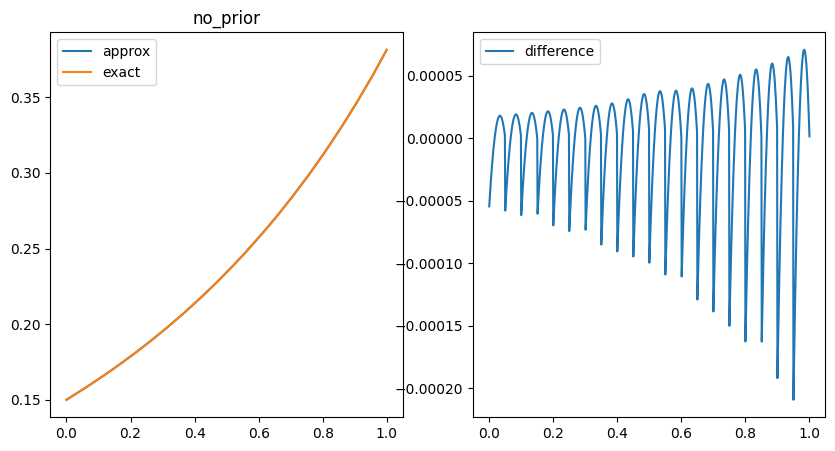

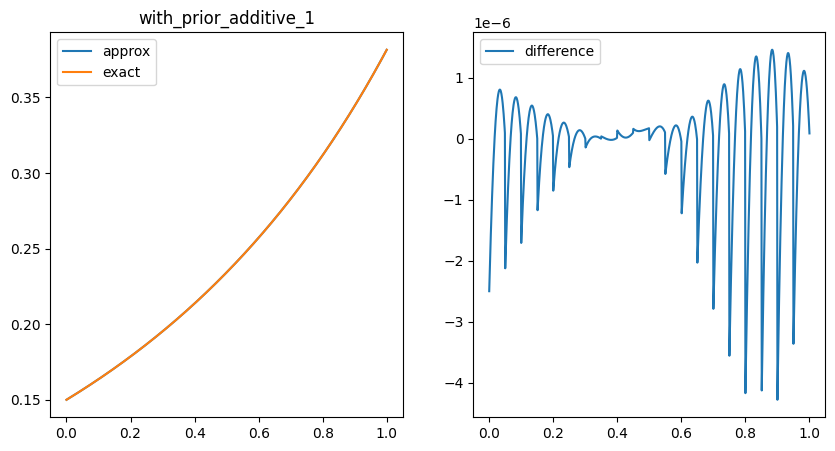

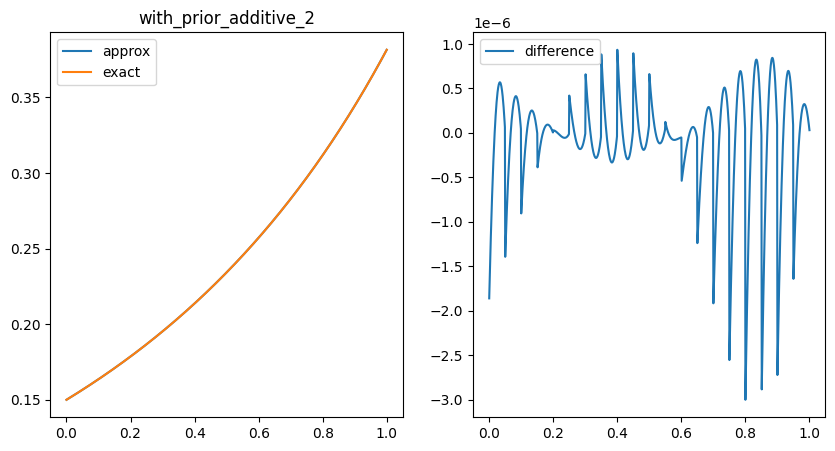

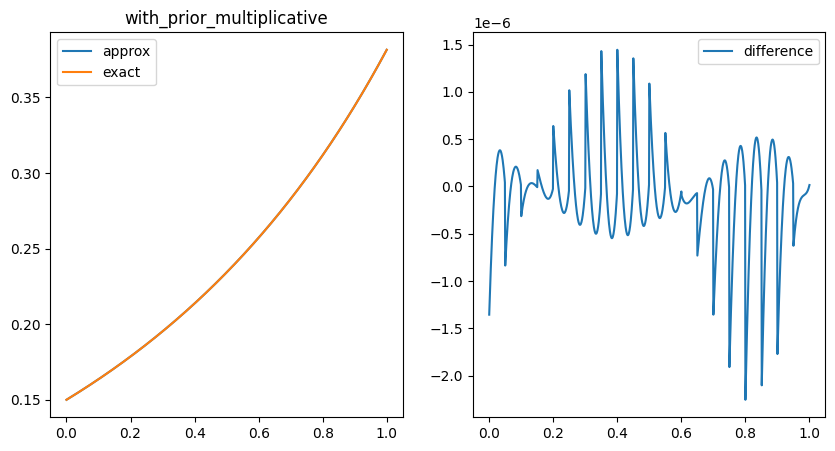

In [8]:
# choose the basis categories you wish to test
categories = [
    "no_prior",
    "with_prior_additive_1",
    "with_prior_additive_2",
    "with_prior_multiplicative",
]

# perturbed_initial_condition = True  # runs a perturbation analysis
perturbed_initial_condition = False  # check the scheme output

# in both cases, available optional arguments are:
#   nx, integer, the number of space points
#   nG, integer, the number of basis function
#   source, bool, whether to add the source term
#   end_time, float, the final computation time

if perturbed_initial_condition:
    run_perturbation_analysis(categories, basis_functions, model_args)
else:
    source = True  # approximation of a steady solution
    # source = False  # pure advection of a Gaussian bump
    run_and_plot(categories, basis_functions, model_args, source=source)